In [20]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import pandas as pd
import os
from pathlib import Path
from tqdm.auto import tqdm
import scipy.stats as stats
from transformers import AutoProcessor, BlipForConditionalGeneration, VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer #, Blip2ForConditionalGeneration 
from utils import calculate_ppl, stat_test_differences, result_to_df, plot_groups
import pickle

2023-12-30 10:23:41.994731: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
class ReportingBiasDataset(Dataset):
    def __init__(self, csv_file, img_dir=None, base_dir='/srv/data/gussodato/'):
        '''TODO explain imgdir vs basedir
        '''
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.base_dir = base_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if self.img_dir:
            img = Image.open(os.path.join(self.img_dir, self.df['2'][idx]))
        else:
            img = Image.open(os.path.join(self.base_dir, self.df['3'][idx], self.df['2'][idx]))
        if img.mode != "RGB":
            img = img.convert(mode="RGB")        
        text = self.df['1'][idx]
        x = {'text': text, 'img': img}
        return x

In [13]:
class ModelTester():
    '''
    
    '''
    def __init__(self, dataset_dict):

        self.data = dataset_dict
        self.blip = BlipForConditionalGeneration.from_pretrained('Salesforce/blip-image-captioning-base')
        self.vit_gpt2 = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
        self.blip_processor = AutoProcessor.from_pretrained('Salesforce/blip-image-captioning-base')
        self.vit_image_processor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
        self.gpt2_tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")


    def test_blip(self, device=torch.device('cuda:0')):
        res = self.test_model(self.blip, device)
        stat = stat_test_differences(res)
        print(stat)
        return stat

    def test_vit_gpt2(self, device=torch.device('cuda:0')):
        res = self.test_model(self.vit_gpt2, device)
        stat = stat_test_differences(res)
        print(stat)
        return stat
    
    def test_model(self, model, device):
        ppl_dict = {}
        model.to(device)
        name = model._get_name()
        print(f'Testing model {name}\n')
        for key, dataset in self.data.items():
            print(f'Testing {key}...')
            if name == 'BlipForConditionalGeneration':
                ppl_dict[key] = self.test_subset_blip(dataset, device)
            elif name == 'VisionEncoderDecoderModel':
                ppl_dict[key] = self.test_subset_vitgpt2(dataset, device)
    
        print('Saving results...')
        resultdir = '../data/results'
        if not Path(resultdir).is_dir():
            os.mkdir(resultdir) 
        outfile = os.path.join(resultdir, name+'_ppls.pickle') 
        with open(outfile, 'wb') as f:
            pickle.dump(ppl_dict, f)
        print(f'Saved results as {outfile}')   
        print('Done!')
        return ppl_dict
             
    def test_subset_blip(self, dataset, device):
        ppls = []
        for i in tqdm(range(len(dataset))):
            item = dataset[i]
            encoded = self.blip_processor(images=item['img'], text=item['text'], return_tensors='pt')
            output = self.blip(pixel_values=encoded['pixel_values'].to(device), input_ids=encoded['input_ids'].to(device), labels=encoded['input_ids'].to(device))
            ppls.append(float(torch.exp(output.loss)))        
        return ppls
   
    def test_subset_vitgpt2(self, dataset, device):
        ppls = []
        for i in tqdm(range(len(dataset))):
            item = dataset[i]
            text = self.gpt2_tokenizer(item['text'], return_tensors='pt')['input_ids'].to(device)
            img = self.vit_image_processor(images=item['img'], return_tensors='pt')['pixel_values'].to(device)
            output = self.vit_gpt2(pixel_values=img, labels=text)
            ppls.append(float(torch.exp(output['loss'])))     
        return ppls


In [14]:
img_dir = '/srv/data/gussodato/images/'

testsets = {
    'test_group_with_attribute': ReportingBiasDataset('../data/dataset/test_mention.csv', img_dir=img_dir),
    'test_group_no_attribute': ReportingBiasDataset('../data/dataset/test_no_mention.csv', img_dir=img_dir),
    'norm_group_with_attribute': ReportingBiasDataset('../data/dataset/norm_mention.csv', img_dir=img_dir),
    'norm_group_no_attribute': ReportingBiasDataset('../data/dataset/norm_no_mention.csv', img_dir=img_dir)    
}

In [15]:
tester = ModelTester(testsets)

In [9]:
tester.test_blip(device=torch.device('cuda:0'))

Testing model BlipForConditionalGeneration

Testing test_group_with_attribute...


  0%|          | 0/680 [00:00<?, ?it/s]

Testing test_group_no_attribute...


  0%|          | 0/680 [00:00<?, ?it/s]

Testing norm_group_with_attribute...


  0%|          | 0/633 [00:00<?, ?it/s]

Testing norm_group_no_attribute...


  0%|          | 0/633 [00:00<?, ?it/s]

Saving results...
Saved results as ../data/results/BlipForConditionalGeneration_ppls.pickle
Done!
TtestResult(statistic=11.397188022437641, pvalue=1.1300550820930935e-28, df=1226.4198298233139)


TtestResult(statistic=11.397188022437641, pvalue=1.1300550820930935e-28, df=1226.4198298233139)

In [16]:
tester.test_vit_gpt2(device=torch.device('cuda:1'))

Testing model VisionEncoderDecoderModel

Testing test_group_with_attribute...


  0%|          | 0/680 [00:00<?, ?it/s]

Testing test_group_no_attribute...


  0%|          | 0/680 [00:00<?, ?it/s]

Testing norm_group_with_attribute...


  0%|          | 0/633 [00:00<?, ?it/s]

Testing norm_group_no_attribute...


  0%|          | 0/633 [00:00<?, ?it/s]

Saving results...
Saved results as ../data/results/VisionEncoderDecoderModel_ppls.pickle
Done!
Shapiro test result for norm group differences: ShapiroResult(statistic=0.34410959482192993, pvalue=1.3998971658604923e-42)
Shapiro test result for test group differences: ShapiroResult(statistic=0.10619604587554932, pvalue=0.0)
t-test result may be unreliable.
TtestResult(statistic=6.349462902290924, pvalue=3.2339316888530864e-10, df=1030.5799149987708)


TtestResult(statistic=6.349462902290924, pvalue=3.2339316888530864e-10, df=1030.5799149987708)

In [3]:
with open('../data/results/BlipForConditionalGeneration_ppls.pickle', 'rb') as f:
    blip_ppls = pickle.load(f)
with open('../data/results/VisionEncoderDecoderModel_ppls.pickle', 'rb') as f:
    vg_ppls = pickle.load(f)
blip_df, vg_df = result_to_df(blip_ppls), result_to_df(vg_ppls)

In [6]:
!mkdir ../data/plots

<Axes: xlabel='Group', ylabel='Model perplexity'>

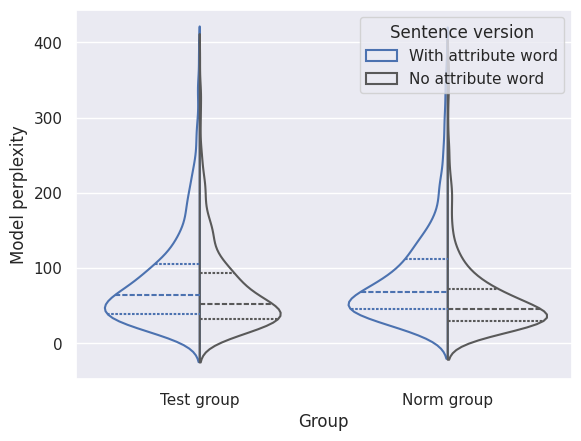

In [18]:
plot_groups(blip_df, savepath='../data/plots/blip_results.png', theme='darkgrid')

<Axes: xlabel='Group', ylabel='Model perplexity'>

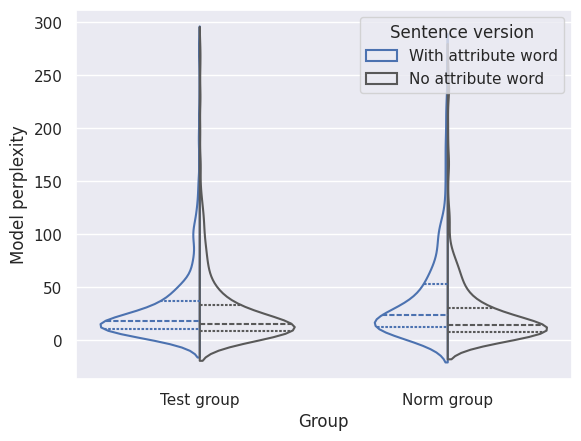

In [19]:
plot_groups(vg_df, savepath='../data/plots/vit-gpt2_results.png', theme='darkgrid')